In [1]:
#This data has been gathered at two solar power plants in India over a 34 day period. 

#It has two pairs of files - each pair has one power generation dataset and one sensor readings dataset. 

#The power generation datasets are gathered at the inverter level - each inverter has multiple lines of 
#solar panels attached to it. 

#The sensor data is gathered at a plant level - single array of sensors optimally placed at the plant.



In [2]:
#There are a few areas of concern at the solar power plant -

# 1) Can we predict the power generation for next couple of days? - this allows for better grid management
# 2) Can we identify the need for panel cleaning/maintenance?
# 3) Can we identify faulty or suboptimally performing equipment?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

In [2]:
df_yield = pd.read_csv("Plant_1_Generation_Data.csv")


In [3]:
print(np.sum(df_yield.isna(),axis=0))

DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64


In [4]:
df_weather = pd.read_csv("Plant_1_Weather_Sensor_Data.csv")


In [5]:
print(np.sum(df_weather.isna(),axis=0))

DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


In [6]:
source_keys = np.unique(df_yield['SOURCE_KEY'])

In [7]:
# Fem un drop de la columna PLANT_ID als dos datasets

In [8]:
df_yield = df_yield.drop(["PLANT_ID"], axis=1)
df_weather = df_weather.drop(["PLANT_ID","SOURCE_KEY"], axis=1)


In [9]:
inverters_list = [ (df_yield.loc[df_yield['SOURCE_KEY']== inverter]).reset_index() for inverter in source_keys]
inverters_list = [inverter.drop(['index'],axis=1) for inverter in inverters_list]

for i in range(len(inverters_list)):
    inverters_list[i]['DATE_TIME'] = pd.to_datetime(inverters_list[i]['DATE_TIME'])
df_weather['DATE_TIME'] = pd.to_datetime(df_weather['DATE_TIME'])

inverters_list = [pd.merge(inverter, df_weather, on='DATE_TIME', how='inner') for inverter in inverters_list]



In [10]:
#Fem un split del date time en noves columnes pels dies, hores, minuts, etc


for i in range(len(inverters_list)):
    inverters_list[i]['DAY'] = inverters_list[i]['DATE_TIME'].dt.day
    inverters_list[i]['MONTH'] = inverters_list[i]['DATE_TIME'].dt.month
    inverters_list[i]['YEAR'] = inverters_list[i]['DATE_TIME'].dt.year
    inverters_list[i]['HOUR'] = inverters_list[i]['DATE_TIME'].dt.hour
    inverters_list[i]['MINUTE'] = inverters_list[i]['DATE_TIME'].dt.minute
    inverters_list[i]['SECOND'] = inverters_list[i]['DATE_TIME'].dt.second
    inverters_list[i] = inverters_list[i].drop(['DATE_TIME','SECOND','YEAR'], axis=1)

In [11]:
first_inverter_df = inverters_list[0]
first_inverter_df = first_inverter_df.drop(['SOURCE_KEY','DC_POWER'],axis=1)
first_inverter_df

,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,MONTH,HOUR,MINUTE
0,0.0,0.0,6259559.0,25.184316,22.857507,0.0,15,5,0,0
1,0.0,0.0,6259559.0,25.084589,22.761668,0.0,15,5,0,15
2,0.0,0.0,6259559.0,24.935753,22.592306,0.0,15,5,0,30
3,0.0,0.0,6259559.0,24.846130,22.360852,0.0,15,5,0,45
4,0.0,0.0,6259559.0,24.621525,22.165423,0.0,15,5,1,0
...,...,...,...,...,...,...,...,...,...,...
2094,0.0,5521.0,6485319.0,22.150570,21.480377,0.0,17,6,22,45
2095,0.0,5521.0,6485319.0,22.129816,21.389024,0.0,17,6,23,0
2096,0.0,5521.0,6485319.0,22.008275,20.709211,0.0,17,6,23,15
2097,0.0,5521.0,6485319.0,21.969495,20.734963,0.0,17,6,23,30


In [12]:
import xgboost as xgb
import math

def r2_eval(Y_pred, train_data):
    labels = train_data.get_label()
    r2 = r2_score(labels, Y_pred)
    return 'r2', r2

def mae_eval(Y_pred, train_data):
    labels = train_data.get_label()
    mae = mean_absolute_error(labels, Y_pred)
    return 'mae', mae

def add_lagged_features(df, num_lags, test_size=0.1):
    #Hem fet el shift correctament de tal manera que el test només té valors lagged del train
    for i in range(1,num_lags):
        df[f'AC_POWER_t{i}'] = df['AC_POWER'].shift(math.floor(test_size*len(df)) + num_lags - i)
        df[f'IRRADIATION_t{i}'] = df['IRRADIATION'].shift(math.floor(test_size*len(df)) + num_lags - i)
        df[f'AMB_TEMP_t{i}'] = df['AMBIENT_TEMPERATURE'].shift(math.floor(test_size*len(df)) + num_lags - i)
        #df[f'MOD_TEMP_t{i}'] = df['MODULE_TEMPERATURE'].shift(math.floor(test_size*len(df)) + num_lags - i)
        
    return df.dropna()

def make_target(df, attribute_name):
    Y = df[attribute_name]
    return df.drop([attribute_name,'IRRADIATION','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE'],axis=1), Y
    

lagged_df = add_lagged_features(first_inverter_df,20,0.1)

X, Y = make_target(lagged_df, 'AC_POWER')



In [13]:
X.keys()

Index(['DAILY_YIELD', 'TOTAL_YIELD', 'DAY', 'MONTH', 'HOUR', 'MINUTE',
       'AC_POWER_t1', 'IRRADIATION_t1', 'AMB_TEMP_t1', 'AC_POWER_t2',
       'IRRADIATION_t2', 'AMB_TEMP_t2', 'AC_POWER_t3', 'IRRADIATION_t3',
       'AMB_TEMP_t3', 'AC_POWER_t4', 'IRRADIATION_t4', 'AMB_TEMP_t4',
       'AC_POWER_t5', 'IRRADIATION_t5', 'AMB_TEMP_t5', 'AC_POWER_t6',
       'IRRADIATION_t6', 'AMB_TEMP_t6', 'AC_POWER_t7', 'IRRADIATION_t7',
       'AMB_TEMP_t7', 'AC_POWER_t8', 'IRRADIATION_t8', 'AMB_TEMP_t8',
       'AC_POWER_t9', 'IRRADIATION_t9', 'AMB_TEMP_t9', 'AC_POWER_t10',
       'IRRADIATION_t10', 'AMB_TEMP_t10', 'AC_POWER_t11', 'IRRADIATION_t11',
       'AMB_TEMP_t11', 'AC_POWER_t12', 'IRRADIATION_t12', 'AMB_TEMP_t12',
       'AC_POWER_t13', 'IRRADIATION_t13', 'AMB_TEMP_t13', 'AC_POWER_t14',
       'IRRADIATION_t14', 'AMB_TEMP_t14', 'AC_POWER_t15', 'IRRADIATION_t15',
       'AMB_TEMP_t15', 'AC_POWER_t16', 'IRRADIATION_t16', 'AMB_TEMP_t16',
       'AC_POWER_t17', 'IRRADIATION_t17', 'AMB_TEMP_t17'

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=False, random_state=42)

train_data = xgb.DMatrix(X_train,label = Y_train)
test_data = xgb.DMatrix(X_test, label = Y_test)

params = {
    'max_depth':3,
    'eta':0.1,
    'objective':'reg:squarederror'
}


In [21]:
model = xgb.XGBRegressor()
model.fit(X_train, Y_train)

Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
sorted_importances = feature_importances.sort_values(ascending=False)

print(sorted_importances)

HOUR               0.753247
IRRADIATION_t18    0.048973
AC_POWER_t17       0.019950
DAILY_YIELD        0.017312
IRRADIATION_t10    0.013874
                     ...   
IRRADIATION_t7     0.000420
AC_POWER_t3        0.000375
IRRADIATION_t3     0.000343
AC_POWER_t14       0.000128
MONTH              0.000000
Length: 63, dtype: float32


In [22]:

mae = mean_absolute_error(Y_test, Y_test_pred)
print(f" Test MAE Score: {mae}")

mae = mean_absolute_error(Y_train, Y_train_pred)
print(f"Train MAE Score: {mae}")

 Test MAE Score: 73.72500758815566
Train MAE Score: 3.586099648615849


In [23]:
r2 = r2_score(Y_test, Y_test_pred)
print(f" Test r2 Score: {r2}")

r2 = r2_score(Y_train, Y_train_pred)
print(f"Train r2 Score: {r2}")

 Test r2 Score: 0.8286482314766418
Train r2 Score: 0.999762840456143


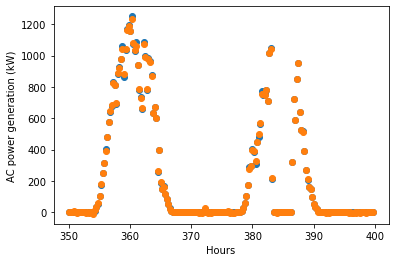

In [24]:
#Valors reals del train vs valors predict del train
x = np.arange(1400,1600)
plt.scatter(x/4, Y_train[x+228])
plt.scatter(x/4, Y_train_pred[x])
plt.xlabel('Hours')
plt.ylabel('AC power generation (kW)')

plt.show()

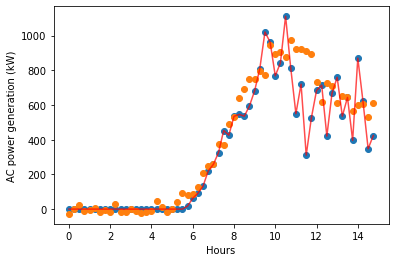

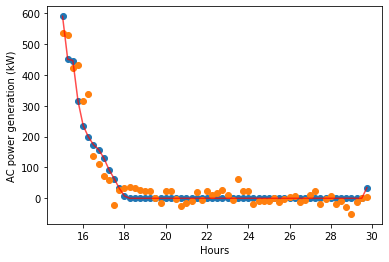

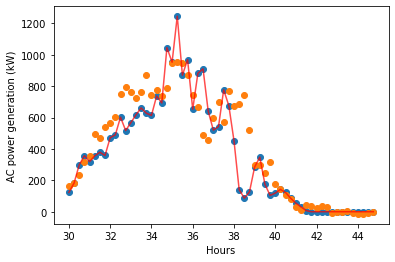

In [25]:
#for i in range(0,180,60):
x = np.arange(0,60)
plt.scatter(x/4, Y_test[x+1911])
plt.plot(x/4, Y_test[x+1911], linestyle='-', color='red', alpha=0.7, label='Connected')
plt.scatter(x/4,Y_test_pred[x])
plt.xlabel('Hours')
plt.ylabel('AC power generation (kW)')

plt.show()

x = np.arange(60,120)
plt.scatter(x/4, Y_test[x+1911])
plt.plot(x/4, Y_test[x+1911], linestyle='-', color='red', alpha=0.7, label='Connected')
plt.scatter(x/4,Y_test_pred[x])
plt.xlabel('Hours')
plt.ylabel('AC power generation (kW)')

plt.show()

x = np.arange(120,180)
plt.scatter(x/4, Y_test[x+1911])
plt.plot(x/4, Y_test[x+1911], linestyle='-', color='red', alpha=0.7, label='Connected')
plt.scatter(x/4,Y_test_pred[x])
plt.xlabel('Hours')
plt.ylabel('AC power generation (kW)')

plt.show()

In [27]:
np.set_printoptions(precision=6, suppress=True)

#Aqui calculem el MAPE però només quans els valors reals no son 0 perquè sinó ens donaria infinit, 
#és a dir, només ho calculem quant és de dia, que ve a ser la part que més ens importa

mean_rel_err = 0
cnt = 0
for real, pred in zip(np.array(Y_test),np.array(Y_test_pred)):
    if (real != 0):
        mean_rel_err += abs(real - pred)/ real
        cnt +=1
    
mean_rel_err = mean_rel_err / cnt
print(mean_rel_err)

0.5589804382544825


In [15]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [22]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_norm = sc.fit_transform(X_train)
X_test_norm = sc.fit_transform(X_test)
Y_train_norm = sc.fit_transform(np.array(Y_train).reshape(-1,1))
#Y_test_norm = sc.fit_transform(np.array(Y_test).reshape(-1,1))


dt_regressor = DecisionTreeRegressor(max_depth=15,min_samples_split=5,min_samples_leaf=4)

models = { #'AdaBoostRegressor':
          #{'model': AdaBoostRegressor(base_estimator=dt_regressor),'params': 
           #{'n_estimators':[150,200,300,400],'learning_rate': [0.01,0.1,1,2],'loss':['linear','square','exponential']}},
          
           #'XGBoost':
          #{'model':xgb.XGBRegressor(),'params':
           #{'n_estimators': [50, 100, 150,400],'learning_rate': [0.01, 0.1, 1],'max_depth': [10,15,20,35]}},
          
           'MLPRegressor': 
          {'model': MLPRegressor(max_iter=2000),'params':
           {'hidden_layer_sizes': [(100,50,100)],'activation':['relu','tanh'],'alpha':[0.0001, 0.001],
            'learning_rate':['constant', 'invscaling', 'adaptive']}}
        
         }

best_models = {}
#ATENCIÓ: això pot trigar varios (molts) minuts en executar-se
for model_name, model_params in models.items():
    time_series_cv = TimeSeriesSplit(n_splits=5)
    reg = GridSearchCV(model_params['model'], model_params['params'], cv=time_series_cv, return_train_score=False,verbose=2)
    reg.fit(X_train_norm, Y_train_norm)
    best_models[model_name] = {'model':reg.best_estimator_ ,'params':reg.best_params_ ,'score':reg.best_score_ }


Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=constant; total time=   0.4s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=constant; total time=   0.6s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=constant; total time=   0.6s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=constant; total time=   1.5s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=constant; total time=   0.9s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=invscaling; total time=   0.6s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=invscaling; total time=   0.6s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=invscaling; total time=   0.6s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=invscaling; total time=   1.2s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=invscaling; total time=   0.4s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive; total time=   0.4s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive; total time=   0.6s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive; total time=   0.8s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive; total time=   1.2s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive; total time=   0.7s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=constant; total time=   0.4s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=constant; total time=   0.6s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=constant; total time=   0.8s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=constant; total time=   1.4s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=constant; total time=   0.7s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=invscaling; total time=   0.3s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=invscaling; total time=   0.5s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=invscaling; total time=   0.6s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=invscaling; total time=   1.2s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=invscaling; total time=   1.0s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive; total time=   0.4s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive; total time=   0.6s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive; total time=   0.8s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive; total time=   1.7s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive; total time=   0.8s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=constant; total time=   0.5s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=constant; total time=   0.8s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=constant; total time=   0.8s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=constant; total time=   1.3s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=constant; total time=   1.0s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=invscaling; total time=   0.5s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=invscaling; total time=   0.6s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=invscaling; total time=   1.0s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=invscaling; total time=   1.0s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=invscaling; total time=   1.0s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive; total time=   0.4s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive; total time=   0.9s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive; total time=   0.9s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive; total time=   1.8s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive; total time=   1.0s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=constant; total time=   0.4s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=constant; total time=   0.8s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=constant; total time=   0.8s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=constant; total time=   2.2s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=constant; total time=   0.9s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=invscaling; total time=   0.4s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=invscaling; total time=   0.4s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=invscaling; total time=   1.2s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=invscaling; total time=   1.4s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=invscaling; total time=   1.3s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive; total time=   0.5s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive; total time=   0.6s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive; total time=   0.7s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive; total time=   1.5s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive; total time=   0.9s


/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [23]:
#Score dels models segons GridSearch
for model_name, model_params in best_models.items():
    print(model_name, " amb paràmetres ", model_params['params'], " té un score de ", model_params['score'])

MLPRegressor  amb paràmetres  {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50, 100), 'learning_rate': 'adaptive'}  té un score de  0.08070944860494747


In [24]:
#Score segons la nostra mètrica escollida
for model_name, model_params in best_models.items():
    Y_test_pred_norm = model_params['model'].predict(X_test_norm)
    Y_train_pred_norm = model_params['model'].predict(X_train_norm)
    
    Y_test_pred = sc.inverse_transform(Y_test_pred_norm)
    Y_train_pred = sc.inverse_transform(Y_train_pred_norm)
    
    mae = mean_absolute_error(Y_test, Y_test_pred)
    print(f"Test MAE Score for {model_name}: {mae}")

    mae = mean_absolute_error(Y_train, Y_train_pred)
    print(f"Train MAE Score for {model_name}: {mae}")
    

Test MAE Score for MLPRegressor: 153.19488619331653
Train MAE Score for MLPRegressor: 45.63542342558591


In [25]:
mean_rel_err = 0
cnt = 0
for real, pred in zip(np.array(Y_test),np.array(Y_test_pred)):
    if (real != 0):
        mean_rel_err += abs(real - pred)/ real
        cnt +=1
    
mean_rel_err = mean_rel_err / cnt
print(mean_rel_err)

1.137471801775172


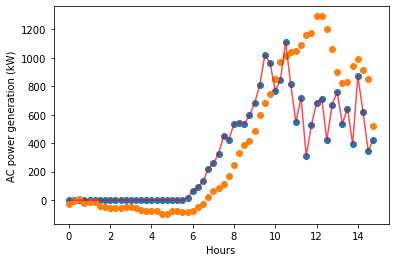

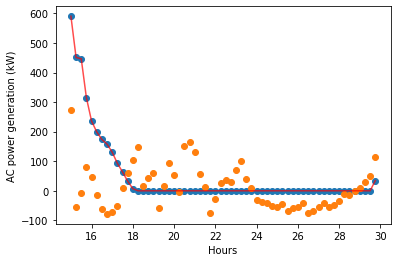

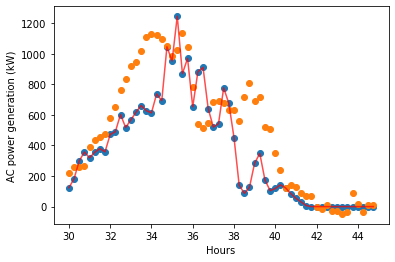

In [26]:
#for i in range(0,180,60):
x = np.arange(0,60)
plt.scatter(x/4, Y_test[x+1911])
plt.scatter(x/4,Y_test_pred[x])
plt.plot(x/4, Y_test[x+1911], linestyle='-', color='red', alpha=0.7, label='Connected')
plt.xlabel('Hours')
plt.ylabel('AC power generation (kW)')

plt.show()


x = np.arange(60,120)
plt.scatter(x/4, Y_test[x+1911])
plt.scatter(x/4,Y_test_pred[x])
plt.plot(x/4, Y_test[x+1911], linestyle='-', color='red', alpha=0.7, label='Connected')
plt.xlabel('Hours')
plt.ylabel('AC power generation (kW)')

plt.show()

x = np.arange(120,180)
plt.scatter(x/4, Y_test[x+1911])
plt.scatter(x/4,Y_test_pred[x])
plt.plot(x/4, Y_test[x+1911], linestyle='-', color='red', alpha=0.7, label='Connected')
plt.xlabel('Hours')
plt.ylabel('AC power generation (kW)')

plt.show()